In [ ]:
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import least_squares, minimize

import archimedes as arc
from archimedes import tree
from archimedes.experimental.sysid import make_pem, lm_solve
from archimedes.experimental.discretize import discretize

from cartpole import CartPole

%load_ext autoreload
%autoreload 2

In [2]:
# Dynamics function
system = CartPole()

x0 = np.array([0.0, 3.0, 0.0, 0.0])  # Initial state

t0, tf = 0.0, 10.0

u0 = np.array([0.0])
dt = 0.01
ts = np.arange(t0, tf, dt)


def f(t, x):
    return system.dynamics(t, x, u0)


xs_true = arc.odeint(f, x0=x0, t_span=(t0, tf), t_eval=ts, rtol=1e-6, atol=1e-8)
# xs = np.zeros((len(ts), 4))
# xs[0] = x0
# for i in range(1, len(ts)):
#     xs[i] = f(ts[i-1], xs[i-1], us[i])

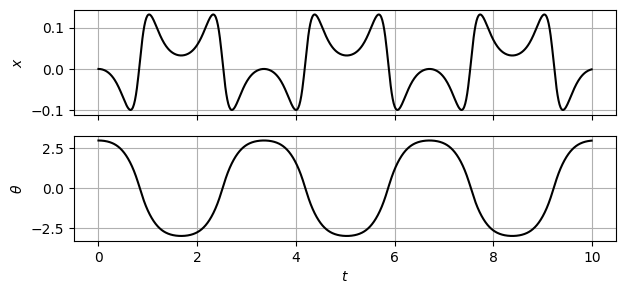

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [ ]:
params_guess = {
    "m1": 0.5,
    "m2": 0.5,
    "L": 1.0,
}

# Optimize the initial condition and parameters
# dvs_guess = x0_guess, params_guess
dvs_guess = params_guess
dvs_guess_flat, unravel = tree.ravel(dvs_guess)

In [5]:
@arc.compile(kind="MX", static_argnames=("fwd",))
def residuals(fwd, dvs_guess_flat):
    xs_pred = fwd(dvs_guess_flat)
    return xs_true - xs_pred

# Shooting

In [ ]:
def ode_rhs(t, x, params):
    model = system.replace(**params)
    return model.dynamics(t, x, u0)


@arc.compile
def fwd_shoot(dvs_flat):
    params = unravel(dvs_flat)

    f = arc.compile(ode_rhs)
    xs_pred = arc.odeint(
        f, x0=x0, t_span=(t0, tf), args=(params,), t_eval=ts, rtol=1e-6, atol=1e-8
    )
    return xs_pred


xs_pred = fwd_shoot(dvs_guess_flat)

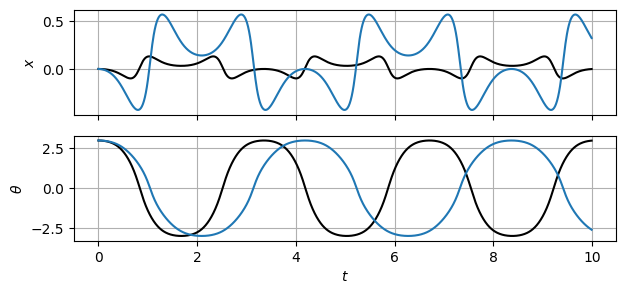

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

In [8]:
residuals(fwd_shoot, dvs_guess_flat)

array([[ 0.00000000e+00,  4.67591519e-05,  1.87098670e-04, ...,
        -3.43393480e-01, -3.34166129e-01, -3.25150538e-01],
       [ 0.00000000e+00, -4.31886669e-05, -1.72941856e-04, ...,
         5.55385712e+00,  5.57794146e+00,  5.60098260e+00],
       [ 0.00000000e+00,  9.35265201e-03,  1.87179290e-02, ...,
         9.32924720e-01,  9.12340719e-01,  8.90595644e-01],
       [ 0.00000000e+00, -8.63989180e-03, -1.73197945e-02, ...,
         2.46099900e+00,  2.35607703e+00,  2.25235321e+00]],
      shape=(4, 1000))

In [9]:
@arc.compile
def obj_shoot(dvs_guess_flat):
    r = residuals(fwd_shoot, dvs_guess_flat)
    r_norm = np.sum(r**2, axis=0)
    xs_norm = np.sum(xs_true**2, axis=0)
    return np.sum(r_norm / xs_norm)


obj_shoot(dvs_guess_flat)

array(2656.63441956)

In [10]:
# def callback(intermediate_result):
#     print(intermediate_result.fun, intermediate_result.x)

# bounds = [(0.0, np.inf) for _ in range(len(dvs_guess_flat))]

# minimize(
#     obj_shoot,
#     dvs_guess_flat,
#     # method="L-BFGS-B",
#     method="trust-constr",
#     jac=arc.jac(obj_shoot),
#     hess=arc.hess(obj_shoot),
#     options={"disp": True},
#     bounds=bounds,
#     callback=callback,
# )

In [11]:
# arc.minimize(obj_shoot, dvs_guess_flat)

# Set up PEM

In [12]:
# Discretize with RK4
dyn = discretize(ode_rhs, dt, method="rk4")


def obs(t, x, dvs_flat):
    return x

In [13]:
nx, ny = 4, 4
Q = np.eye(nx)
R = 1e4 * np.eye(ny)

In [14]:
kf_fwd = make_pem(
    dyn,
    obs,
    ts,
    xs_true,
    Q=Q,
    R=R,
)


In [ ]:
@arc.compile
def pem_func(dvs_flat):
    params = unravel(dvs_flat)
    return kf_fwd(x0, (params,))


pem_func(dvs_guess_flat)

[array(1.86375974),
 array([ 0.03190747, -0.03457325,  0.03457325]),
 array([[ 0.01528813, -0.00795748,  0.00795748],
        [-0.00795748,  0.03362173, -0.03362173],
        [ 0.00795748, -0.03362173,  0.03362173]])]

In [16]:
result = lm_solve(
    pem_func,
    dvs_guess_flat,
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    nprint=1,
)

print(result)

Iteration 0, Cost: 1.86375973648801, Grad norm: 0.03457324710068698
Iteration 1, Cost: 0.17462614369344856, Grad norm: 0.016525591852153885
Iteration 2, Cost: 0.037056406093451864, Grad norm: 0.011475022562137947
Iteration 3, Cost: 0.025396839928777566, Grad norm: 0.01135806295012432
Iteration 4, Cost: 0.010284194653373357, Grad norm: 0.011447652236536484
Iteration 5, Cost: 0.004167391920040649, Grad norm: 0.003917511348128009
Iteration 6, Cost: 0.0016069403738238211, Grad norm: 0.0036395413634147766
Iteration 7, Cost: 0.0009711116902266759, Grad norm: 0.0013464003464068333
Iteration 8, Cost: 0.00036647879654907366, Grad norm: 0.0010966676505925494
Iteration 9, Cost: 0.00030772050310818254, Grad norm: 0.0006565994597929288
Iteration 10, Cost: 0.00014873111859012314, Grad norm: 0.0005558372547492089
Iteration 11, Cost: 0.0001396767074020592, Grad norm: 0.0003799800767758111
Iteration 12, Cost: 9.543269383876185e-05, Grad norm: 0.00029265061835039436
Iteration 13, Cost: 9.349183449047733

In [17]:
# Simulate forward with optimal parameters
dvs_opt_flat = result.x
xs_opt = fwd_shoot(dvs_opt_flat)

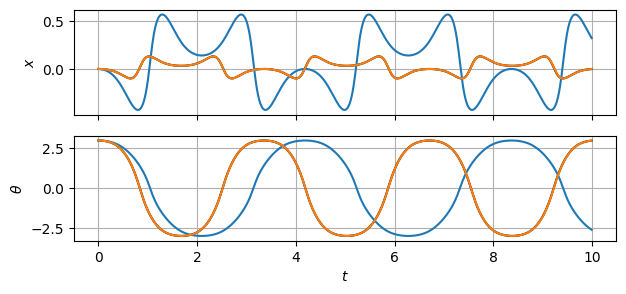

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()

## Also estimate initial condition

In [33]:
kf_fwd = make_pem(
    dyn,
    obs,
    ts,
    xs_true,
    Q=Q,
    R=R,
    optimize_x0=True,
)


x0_guess = np.array([1.0, 3.0, 0.0, 0.0])
dvs_guess = (x0_guess, params_guess)
dvs_guess_flat, unravel = tree.ravel(dvs_guess)

@arc.compile
def pem_func(dvs_flat):
    x0, params = unravel(dvs_flat)
    return kf_fwd(x0, (params,))

pem_func(dvs_guess_flat)

[array(1.94761427),
 array([ 0.10767866,  0.01549155, -0.04262617,  0.02813197,  0.03210277,
        -0.03452129,  0.03452129]),
 array([[ 1.00000000e+00,  1.91500224e-04,  1.00000000e-02,
          8.98840648e-06, -3.12780302e-06,  5.67323088e-07,
         -5.67323088e-07],
        [ 1.91500224e-04,  1.06226107e+00,  3.82212767e-02,
          4.54166329e-02, -1.09293488e-04,  1.56019042e-04,
         -1.56019042e-04],
        [ 1.00000000e-02,  3.82212767e-02,  1.00010000e+00,
          1.80480832e-03, -6.27759096e-04,  1.30586503e-04,
         -1.30586503e-04],
        [ 8.98840648e-06,  4.54166329e-02,  1.80480832e-03,
          1.00139456e+00, -1.64394529e-03, -8.11998124e-04,
          8.11998124e-04],
        [-3.12780302e-06, -1.09293488e-04, -6.27759096e-04,
         -1.64394529e-03,  1.52946699e-02, -7.96092033e-03,
          7.96092033e-03],
        [ 5.67323088e-07,  1.56019042e-04,  1.30586503e-04,
         -8.11998124e-04, -7.96092033e-03,  3.36399296e-02,
         -3.3639

In [ ]:
result = lm_solve(
    pem_func,
    dvs_guess_flat,
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    nprint=10,
    maxfev=1000,
)

print(result.success, result.message)

Iteration 0, Cost: 1.94761427121214, Grad norm: 0.1076786647827159
Iteration 10, Cost: 0.06944729074327236, Grad norm: 0.10735592982767331
Iteration 20, Cost: 0.04835385387417035, Grad norm: 0.0935892590895153
Iteration 30, Cost: 0.036248999441860504, Grad norm: 0.08111894458285122
Iteration 40, Cost: 0.027125066474250156, Grad norm: 0.0711439985273186
Iteration 50, Cost: 0.019462174536680418, Grad norm: 0.060717380179803625
Iteration 60, Cost: 0.013589314723282715, Grad norm: 0.05046958401557528
Iteration 70, Cost: 0.009959786249262949, Grad norm: 0.043766706896146666
Iteration 80, Cost: 0.007402510531017016, Grad norm: 0.03598180239466049
Iteration 90, Cost: 0.0047932371844380504, Grad norm: 0.030374543677369737
Iteration 100, Cost: 0.003443809326847753, Grad norm: 0.02550915169363035
Iteration 110, Cost: 0.0024629917378121307, Grad norm: 0.02174910990916616
Iteration 120, Cost: 0.001582997648101375, Grad norm: 0.01735049598735766
Iteration 130, Cost: 0.0011082823435002009, Grad norm

In [35]:
result.nfev

238

In [36]:
# Simulate forward with optimal parameters
@arc.compile
def fwd_shoot(dvs_flat):
    x0, params = unravel(dvs_flat)

    f = arc.compile(ode_rhs)
    xs_pred = arc.odeint(
        f, x0=x0, t_span=(t0, tf), args=(params,), t_eval=ts, rtol=1e-6, atol=1e-8
    )
    return xs_pred


dvs_opt_flat = result.x
print(unravel(dvs_opt_flat))
xs_opt = fwd_shoot(dvs_opt_flat)

(array([0.03261757, 3.00120205, 0.03500681, 0.02098417]), {'L': array(0.49996398), 'm1': array(0.71249926), 'm2': array(0.21383741)})


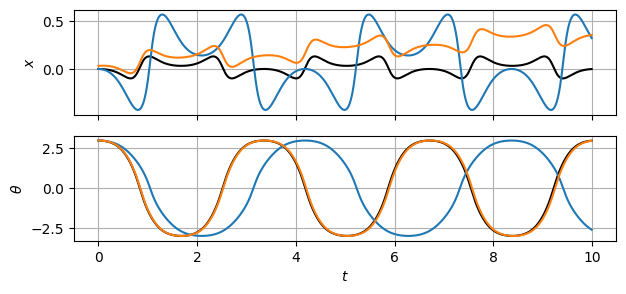

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ts, xs_true[0], c="k")
ax[0].plot(ts, xs_pred[0])
ax[0].plot(ts, xs_opt[0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs_true[1], c="k")
ax[1].plot(ts, xs_pred[1])
ax[1].plot(ts, xs_opt[1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel(r"$t$")

plt.show()